In [1]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm

%matplotlib inline

In [2]:
from Master_Functions import CondExtBivNegLogLik
from DeltaLaplaceFuncs import DeltaLaplace

In [3]:
# For module development

%load_ext autoreload
%autoreload 2

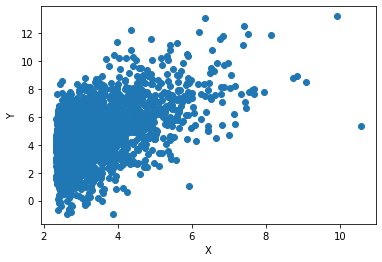

In [84]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(50000)

#We'll also let Z be Delta_Laplace noise

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X = X[X>u]
Z = DeltaLaplace(loc =1,scale = 1,shape = 1.5).rvs(size=len(X), random_state =2)

Y = 0.9 * X + Z*(X**0.4)


fig=plt.figure()
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [88]:
## Fit distribution. We will use Delta-Laplace margins.

init_par=[0.5,0.2,0.2,0.5,2]

X_data, Y_data = X,Y

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par, args=(X_data,Y_data,True),
               method="Nelder-Mead")
fit  = minimize(fun = CondExtBivNegLogLik,x0 = init_par, args=(X_data,Y_data,True),
               method="BFGS")

fit

/home/flettj/CondExtremesPy/DeltaLaplaceFuncs.py:25: RuntimeWarning: divide by zero encountered in true_divide
  ld = -abs((x - mu) / sigma) ** delta + np.log(delta) - np.log(2 * sigma) - gamma(1 / delta)
/home/flettj/CondExtremesPy/DeltaLaplaceFuncs.py:25: RuntimeWarning: divide by zero encountered in log
  ld = -abs((x - mu) / sigma) ** delta + np.log(delta) - np.log(2 * sigma) - gamma(1 / delta)
/home/flettj/CondExtremesPy/DeltaLaplaceFuncs.py:25: RuntimeWarning: invalid value encountered in subtract
  ld = -abs((x - mu) / sigma) ** delta + np.log(delta) - np.log(2 * sigma) - gamma(1 / delta)


      fun: 7675.014263796111
 hess_inv: array([[ 0.39750539, -0.16193457, -0.54722896, -0.0113504 , -0.1036906 ],
       [-0.16193457,  0.52136077,  0.1405161 , -0.36522641, -0.28208299],
       [-0.54722896,  0.1405161 ,  0.76898746,  0.0823975 ,  0.20130727],
       [-0.0113504 , -0.36522641,  0.0823975 ,  0.3007823 ,  0.26654035],
       [-0.1036906 , -0.28208299,  0.20130727,  0.26654035,  0.25868129]])
      jac: array([-2874.75183105,  -624.40472412, -1229.46130371,  -201.44702148,
        -235.01794434])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 369
      nit: 3
     njev: 60
   status: 2
  success: False
        x: array([0.99541648, 0.27818223, 0.21499855, 1.32288751, 1.09214999])

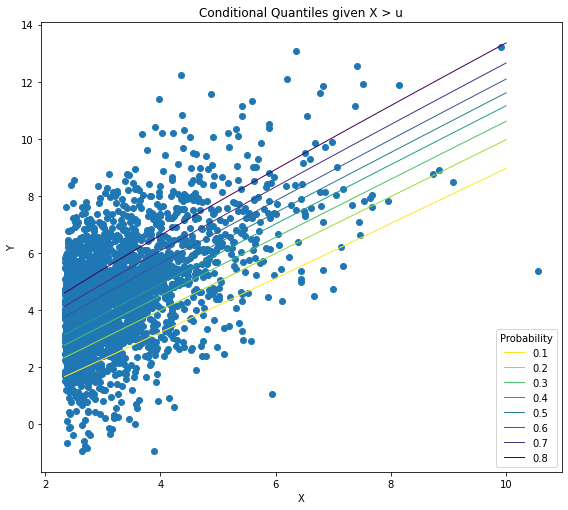

In [89]:
# Overlay conditional quantiles, given X > u, on Scatter plot
alpha,beta,mu,sigma,delta = fit.x

x_seq=np.linspace(u,10,100)
probs=np.arange(0.1,0.9,0.1)

#Quantiles from the data. 
z_hat = (Y - alpha * X)/ X** beta

quants = np.quantile(z_hat, probs)

plt.figure(figsize=(8,7))
plt.scatter(X,Y)
viridis = cm.get_cmap('viridis', len(probs))
for k in range(0,len(probs)):
    
    plt.plot(x_seq,alpha*x_seq+quants[k]*x_seq**beta,color = viridis.colors[-(k+1)], linewidth = 1)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend( np.around(probs,2), loc = 4, title = "Probability")
plt.tight_layout()
plt.title("Conditional Quantiles given X > u")
plt.show()
